<a href="https://colab.research.google.com/github/tianchu-shu/NLP/blob/master/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import seaborn as sns
sns.set()

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
#Data saved in csv/excel
import glob, os

data_dir= '/content/gdrive/My Drive/QB/'
os.chdir(data_dir)

In [5]:
!ls

 2.extracurr-activity-sample_2020.xlsx	 task2.ipynb
 task2.csv				'Untitled presentation.gslides'


In [6]:
df= pd.read_excel("2.extracurr-activity-sample_2020.xlsx", sheet_name='raw-data')

In [7]:
cate= pd.read_excel("2.extracurr-activity-sample_2020.xlsx", sheet_name='categories')
cate.shape

(15, 1)

In [8]:
cate

,Categories
0,Academic
1,Art
2,Athletics
3,Career-Oriented
4,Community Service (Volunteer)
5,Cultural
6,Debate/Speech
7,Environmental
8,Family Responsibilities
9,Foreign Exchange


In [9]:
df.shape

(2000, 8)

In [10]:
df.Category.value_counts()

Other                             892
Other:In School Activities        661
Other:Out of School Activities    337
Other Music:Group                 109
Name: Category, dtype: int64

In [11]:
del df['Main Category _Corrected']

In [12]:
#There are 3 students dont have a Description for their extracurr-activity and they have to be taken out from the text classification
df[df['Description'].isnull()]

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category
1108,1109,2015,F,an organization create called Planeta Junes Ku...,NaN,Other Activity/Club,Other:Out of School Activities
1395,1396,2014,F,NaN,NaN,Other Activity/Club,Other:In School Activities
1536,1537,2014,F,NaN,NaN,Other Activity/Club,Other:In School Activities


In [13]:
target = "Description"

In [14]:
data =df[df[target].notnull()]

In [15]:
#data = data[data.Category!='Other Music:Group']

In [16]:
data.shape

(1997, 7)

## Extracting Keywords

In [17]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['team','club','program']
stopwords.extend(newStopWords)

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = newStopWords
)
tfidf.fit(data[target])
text = tfidf.transform(data[target])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


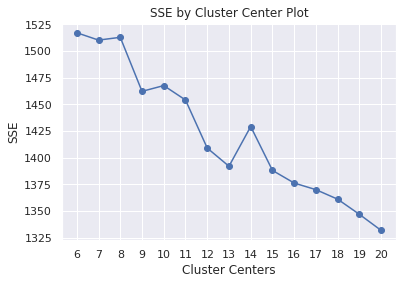

In [18]:
def find_optimal_clusters(data, max_k):
    iters = range(6, max_k+1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

## From the graph above, I determine the number of clusters I would like to keep. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 12 clusters mark. So, we’ll be keeping a 12-cluster solution.

In [19]:
clusters = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

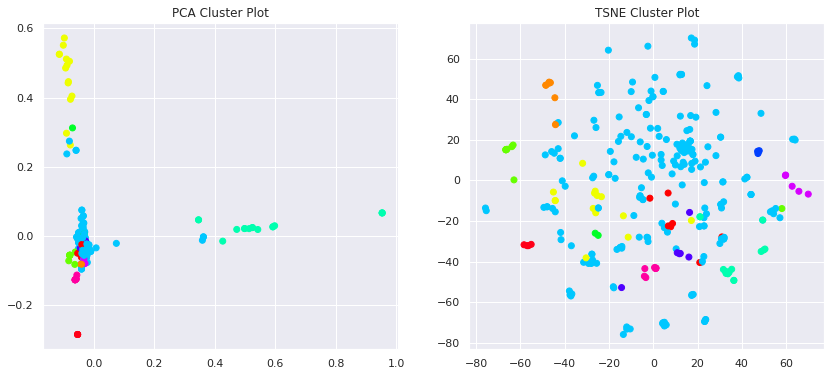

In [25]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    # reduce the features to 2D
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

    
plot_tsne_pca(text,clusters)

In [26]:
def create_newdf(df,col, X, true_k):
	model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
	model.fit(X)
	labels=model.labels_
	newdf=pd.DataFrame(list(zip(df['Student ID'], df[col],labels)), columns =['Student ID', col, 'Main Category _Corrected'])
 
	print(newdf.sort_values(by=['Main Category _Corrected']))
	return newdf

In [27]:
newdf = create_newdf(data, target, clusters.reshape(-1, 1), 12)

      Student ID  ... Main Category _Corrected
1996        2000  ...                        0
984          985  ...                        0
983          984  ...                        0
982          983  ...                        0
981          982  ...                        0
...          ...  ...                      ...
50            51  ...                       11
936          937  ...                       11
1024        1025  ...                       11
1191        1193  ...                       11
1259        1261  ...                       11

[1997 rows x 3 columns]


# Use the target column to classify

In [28]:
from wordcloud import WordCloud
def wordcloud(newdf, col, true_k):
	for k in range(0,true_k):
	   s=newdf[newdf['Main Category _Corrected']==k]
	   text=s[col].str.cat(sep=' ')
	   text=' '.join([word for word in text.split()])
	   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
	   print('Cluster: {}'.format(k))
	   print(target)
	   titles=newdf[newdf['Main Category _Corrected']==k][target][:10]         
	   print(titles.to_string(index=False))
	   plt.figure()
	   plt.imshow(wordcloud, interpolation="bilinear")
	   plt.axis("off")
	   plt.show()

Cluster: 0
Description
     World Games Newspaper Committee (WGNC)
                           Athletic Council
         Interact Club,a volunteering club.
                       2009 Flint Debutante
                            Recording Music
                 Venture Crew (Outing Club)
 Music Department Extracurricular Treasurer
                       Feeding the homeless
                                 Anime Club
  Personal Blog & Founding Online Community


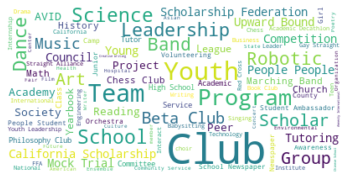

Cluster: 1
Description
                    Future Farmers of America
 Substituting as head of household since 2007
      Health Occupational Students of America
 Family Career and Community Leaders of Amer.
                             top 10% of class
           County of Alameda Youth Leadership
          3rd Chair of Dallas' All-City Band.
            Academy of Information Technology
        Texas Assiciation of Future Educators
            Business Professionals of America


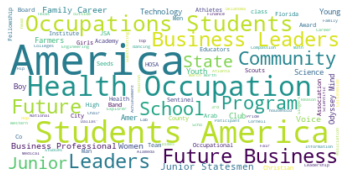

Cluster: 2
Description
  Forensics/Speech
            Speech
 Speech and Debate
            Speech
      Debate Squad
            Speech
 Speech and Debate
            Speech
  Speech and Drama
            Debate


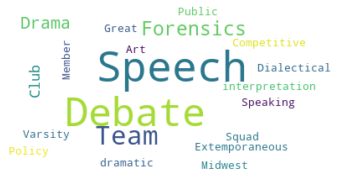

Cluster: 3
Description
 Volunteer Office Assistant in Family Practice
      Volunteer at Children's Hospital Oakland
            Volunteer Elementary Teacher's Aid
               Houston Humane Societ Volunteer
              Church Volunteer Missionary Work
             Volunteer Work for Cancer patient
                                     Volunteer
                 Volunteer at Swedish Hospital
           volunteer work at regional hospital
                volunteer work at nursing home


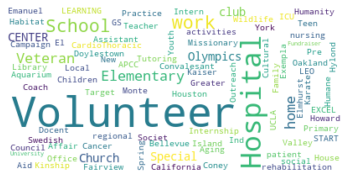

Cluster: 4
Description
                            Student Ambassador
     California Association of Student Council
                         Top Ten Honor Student
                 Progressive Student Awareness
               Student Anti Genocide Coalition
 Youth Congress/Student Advisory Council (SAC)
             Scholarship Exchange Student/Host
           Student Reporter for local magazine
      STAND, A Student Anti-Genocide Coalition
                      Science Research Student


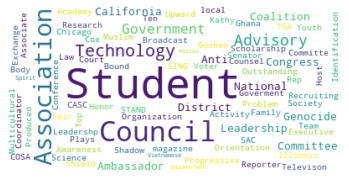

Cluster: 5
Description
                           Concert Choir
                   Varsity Concert Choir
                        Choir/Show Choir
                     Genesis Bells Choir
                                   Choir
                       Lead Choir singer
            Concert Choir, Chamber Choir
                                   Choir
 Jubilate- Jensen Beach Auditioned Choir
                                   Choir


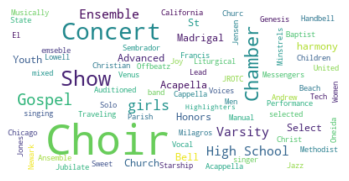

Cluster: 6
Description
                    CPS College Bridge Program
 Middle College National Leadership Conference
                  Personal Non-Paid Math Tutor
                     Saint Louis College Bound
                                   College Now
                                   College Now
                                     math team
                               College Classes
                     Community College Student
                                 College Match


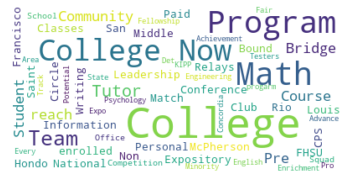

Cluster: 7
Description
                                     Key Club
                                     Key Club
                             Kiwanis Key Club
                                     Key Club
                       Key Club International
 Key Club; build leadership by helping others
                                     Key Club
                                     Key club
                                     Key Club
                                     Key Club


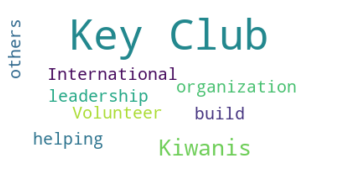

Cluster: 8
Description
  National English Honor Society (NEHS)
            National Art Honors Society
       National Technical Honor Society
       National Technical Honor Society
              Tri-M music Honor Society
         National English Honor Society
      Pink Ribbon Legacy Society (PRLS)
                 National Honor Society
 Multiple Sclerosis Society Fundraising
       National Technical Honor Society


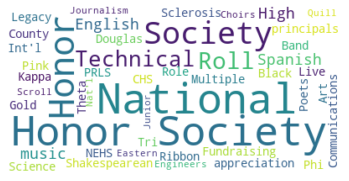

Cluster: 9
Description
 Taking care of my grandmother (2002-2005)
  CARE:Creating-Awareness-Regarding-Equity
          Taking care of my little brother
        Volunteering at Martin Health Care
                I take care of my siblings
                  Right to Health Care Now
                         Irvin Irgent Care
             Taking care of my grandmother
                   Take-a-Brake Child Care
        Household Chores & Care Assistance


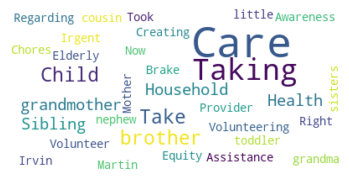

Cluster: 10
Description
                       Concert Chorus
                               Chorus
                               Chorus
                      Ensemble Chorus
                        School Chorus
           Concert Choir/Mixed Chorus
                               Chorus
                               Chorus
 Chorus/Select Choir/Women's Ensamble
                        Womens Chorus


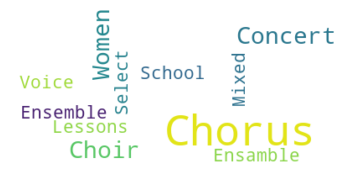

Cluster: 11
Description
                         Summer Honors Program
      Summer Youth Internship Progam at Kaiser
                   summer internship at clinic
        Summer Residential Program at Stanford
                   Salmon Research Summer Camp
                               summer scholars
                         Summer Search Program
 The American Field House (AFS) Summer Program
    Summer internship at Kansas City City Hall
                         CoHRSP Summer Program


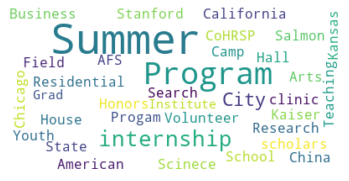

In [29]:
wordcloud(newdf, target, 12)

In [30]:
cate

,Categories
0,Academic
1,Art
2,Athletics
3,Career-Oriented
4,Community Service (Volunteer)
5,Cultural
6,Debate/Speech
7,Environmental
8,Family Responsibilities
9,Foreign Exchange


From the wordCloud, I get to identify most of the clusters' categories. But I am not sure about Cluster 0 and 5, so I will classify them as others for now and may need manual labelling those in the future.

In [ ]:
new_cate ={}

In [ ]:
new_cate[11]='Family Responsibilities'
new_cate[10]='Academic'
new_cate[9]='Community Service (Volunteer)'
new_cate[8]='Art'
new_cate[7]='Academic'
new_cate[6]='Art'
new_cate[4]='Community Service (Volunteer)'
new_cate[3]='Academic'
new_cate[2]='Debate/Speech'
new_cate[1]='Student Government/Politics'
new_cate[5]='Other Activity/Club'
new_cate[0]='Other Activity/Club'

In [ ]:
newdf['Main Category _Corrected'] =newdf['Main Category _Corrected'].replace(new_cate)
newdf.head()

,Student ID,Description,Main Category _Corrected
0,1,Forensics/Speech,Debate/Speech
1,2,World Games Newspaper Committee (WGNC),Other Activity/Club
2,3,Athletic Council,Other Activity/Club
3,4,"Interact Club,a volunteering club.",Other Activity/Club
4,5,2009 Flint Debutante,Other Activity/Club


In [ ]:
index =newdf[newdf.Description.str.contains('volunteer')].index
newdf.loc[index,'Main Category _Corrected'] = 'Community Service (Volunteer)'

Int64Index([3, 308, 309, 758, 1139, 1151, 1225, 1684, 1694, 1877], dtype='int64')

In [ ]:
index =newdf[newdf.Description.str.contains('Athletic')].index
newdf.loc[index,'Main Category _Corrected'] = 'Athletics'


## Evaluation with unlabelled dataset

In [35]:
cls = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20)
cls.fit(text)

MiniBatchKMeans(batch_size=2048, compute_labels=True, init='k-means++',
                init_size=1024, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=3, random_state=20,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(text, labels=cls.predict(text))

0.14133916318404002

In [ ]:
result = pd.merge(df, newdf[['Student ID','Main Category _Corrected']], how='left', on=['Student ID'])

In [ ]:
result.head()

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category,Main Category _Corrected
0,1,2020,F,2nd place districts story-teller,Forensics/Speech,Other Activity/Club,Other,Debate/Speech
1,2,2020,F,Collaboration w/ Kaohsiung Organizing Committe...,World Games Newspaper Committee (WGNC),Other Activity/Club,Other:In School Activities,Other Activity/Club
2,3,2020,F,We organize Sports Day and many other in- and ...,Athletic Council,Other Activity/Club,Other:In School Activities,Athletics
3,4,2020,M,I found an elementary school to tutor kids alo...,"Interact Club,a volunteering club.",Other Activity/Club,Other:In School Activities,Other Activity/Club
4,5,2020,M,NaN,2009 Flint Debutante,Other Activity/Club,Other:Out of School Activities,Other Activity/Club


I realzied there are 109 rows are listed as Other Music:Group in Category column. Those rows can be assigned to Art since music is Art. And I can skip those rows for text classification.

In [ ]:
index = result[result.Category=='Other Music:Group'].index

# now use df.loc to set values only to those rows
result.loc[index,'Main Category _Corrected'] = 'Art'

In [ ]:
result['Main Category _Corrected'].value_counts()

Other Activity/Club              1451
Art                               184
Community Service (Volunteer)     132
Academic                          104
Student Government/Politics        59
Debate/Speech                      42
Family Responsibilities            22
Athletics                           3
Name: Main Category _Corrected, dtype: int64

In [ ]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df.label, cls.predict(features))

In [ ]:
result.to_csv('task2.csv')

In [ ]:
result.to_excel( "2.extracurr-activity-sample_2020.xlsx", sheet_name='raw-data')